# Create and Train Transformer from Scratch

## Helper functions

This code implements key components for building a Transformer model in TensorFlow. It includes a function for scaled dot-product attention, which calculates attention scores between query, key, and value tensors. The `MultiHeadAttention` class extends TensorFlow's Layer class to apply multiple attention heads in parallel, enhancing the model's ability to focus on different parts of the input. Additionally, a position-wise feed-forward network and positional encoding functions are defined, essential for capturing the sequence order of the input data. The positional encoding function computes positional encodings using sine and cosine functions to maintain the order of input tokens.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LayerNormalization, Dropout
import numpy as np

# Define a scaled dot-product attention function
def scaled_dot_product_attention(query, key, value, mask=None):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

# Define multi-head attention layer
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)

        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output

# Define position-wise feed-forward network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        Dense(dff, activation='relu'),
        Dense(d_model)
    ])

# Define positional encoding
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

## Define `EncoderLayer`

The code defines a Transformer encoder using TensorFlow's Keras API. The `EncoderLayer` class represents a single encoder layer with multi-head attention and a feed-forward neural network, each followed by layer normalization and dropout for regularization. The `Encoder` class constructs a stack of multiple `EncoderLayer` instances, embedding input sequences and adding positional encodings to capture sequence information. The encoder processes input sequences through these layers, applying attention mechanisms and feed-forward networks iteratively, ultimately outputting a processed representation suitable for tasks like machine translation or text classification. Both classes utilize dropout for regularization and are designed to handle variable-length input sequences with optional masking.

In [ ]:
# Define encoder layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training=False, mask=None):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# Define the Transformer encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, x, training=False, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x

## Define `TransformerModel`

The provided code defines a custom TensorFlow Transformer model class `TransformerModel` using Keras. The class is decorated with `@tf.keras.utils.register_keras_serializable()` to enable serialization and deserialization. It initializes with model parameters such as the number of layers, model dimensions, attention heads, feed-forward network size, input vocabulary size, position encoding, and dropout rate. The model consists of an encoder layer and a final dense output layer. The `call` method performs a forward pass through the encoder and final layer. `get_config` and `from_config` methods handle the model's configuration serialization and deserialization, allowing the model to be saved and loaded.

In [ ]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1, **kwargs):
        # Pass any additional keyword arguments to the parent class
        super(TransformerModel, self).__init__(**kwargs)

        # Store the model parameters
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.input_vocab_size = input_vocab_size
        self.maximum_position_encoding = maximum_position_encoding
        self.rate = rate

        # Define the layers
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate)
        self.final_layer = tf.keras.layers.Dense(input_vocab_size)

    def call(self, x, training=False, mask=None):
        enc_output = self.encoder(x, training=training, mask=mask)
        final_output = self.final_layer(enc_output)
        return final_output

    def get_config(self):
        config = super(TransformerModel, self).get_config()
        config.update({
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "input_vocab_size": self.input_vocab_size,
            "maximum_position_encoding": self.maximum_position_encoding,
            "rate": self.rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


### Run a `.fit` method with toy data

In [ ]:
# Hyperparameters
num_layers = 2
d_model = 64
dff = 128
num_heads = 4
input_vocab_size = 8500
maximum_position_encoding = 10000

# Instantiate the Transformer model
transformer = TransformerModel(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding)

# Compile the model
transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Generate random sample data
sample_data = np.random.randint(0, input_vocab_size, size=(64, 38))

# Fit the model on the random sample data
transformer.fit(sample_data, sample_data, epochs=5)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.0000e+00 - loss: 15.9414
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 15.3905
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0014 - loss: 14.8311    
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0014 - loss: 14.4278    
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 8.2237e-04 - loss: 14.3109


The code imports TensorFlow, pandas, numpy, and Keras preprocessing utilities, then creates a pandas DataFrame containing sample question-answer pairs. The DataFrame, `df`, is manually populated with a dictionary containing questions (e.g., "What is the capital of France?") and their corresponding answers (e.g., "The capital of France is Paris."). An alternative option to create the DataFrame from a CSV file is provided but commented out. The code initializes the data processing environment, potentially for further natural language processing (NLP) tasks such as tokenization or sequence padding using TensorFlow and Keras tools.

## Create a `pd` dataframe

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create a sample pandas DataFrame
data = {
    'question': [
        'What is the capital of France?',
        'How many continents are there?',
        'What is the largest mammal?',
        'Who wrote the play Hamlet?'
    ],
    'answer': [
        'The capital of France is Paris.',
        'There are seven continents.',
        'The blue whale is the largest mammal.',
        'William Shakespeare wrote Hamlet.'
    ]
}

# Or read it from directory
# data = pd.DataFrame("test.csv")

df = pd.DataFrame(data)
df

,question,answer
0,What is the capital of France?,The capital of France is Paris.
1,How many continents are there?,There are seven continents.
2,What is the largest mammal?,The blue whale is the largest mammal.
3,Who wrote the play Hamlet?,William Shakespeare wrote Hamlet.


In [ ]:
import pandas as pd

df = pd.read_parquet("hf://datasets/eagle0504/storySeed-v1/data/train-00000-of-00001.parquet")
df

,questions,answers,text
0,Please help me create a picture book with the ...,Title: Whisker's Magical Forest Adventure\n\n...,### Human: Please help me create a picture boo...
1,Please help me create a picture book with the ...,Title: **Mia and Mico’s Treasure Quest**\n\n ...,### Human: Please help me create a picture boo...
2,Please help me create a picture book with the ...,Title: The Enchanted Doorway\n\n---\n\n# Cove...,### Human: Please help me create a picture boo...
3,Please help me create a picture book with the ...,"Title: ""The Cave of Dragon Friends""\n\n---\n\...",### Human: Please help me create a picture boo...
4,Please help me create a picture book with the ...,Title: Pip's Quest for the Golden Cheese\n\n ...,### Human: Please help me create a picture boo...
...,...,...,...
95,Please help me create a picture book with the ...,Title: **The Bear Cubs' Prehistoric Express**...,### Human: Please help me create a picture boo...
96,Please help me create a picture book with the ...,Title: Ember's Quest for the Rainbow Feather\...,### Human: Please help me create a picture boo...
97,Please help me create a picture book with the ...,Title: **Stella and Fidget in Starlight Adven...,### Human: Please help me create a picture boo...
98,Please help me create a picture book with the ...,Title: The Quest for the Wishing Carrot\n\n C...,### Human: Please help me create a picture boo...


In [ ]:
df.columns = ["question", "answer", "text"]
df

,question,answer,text
0,Please help me create a picture book with the ...,Title: Whisker's Magical Forest Adventure\n\n...,### Human: Please help me create a picture boo...
1,Please help me create a picture book with the ...,Title: **Mia and Mico’s Treasure Quest**\n\n ...,### Human: Please help me create a picture boo...
2,Please help me create a picture book with the ...,Title: The Enchanted Doorway\n\n---\n\n# Cove...,### Human: Please help me create a picture boo...
3,Please help me create a picture book with the ...,"Title: ""The Cave of Dragon Friends""\n\n---\n\...",### Human: Please help me create a picture boo...
4,Please help me create a picture book with the ...,Title: Pip's Quest for the Golden Cheese\n\n ...,### Human: Please help me create a picture boo...
...,...,...,...
95,Please help me create a picture book with the ...,Title: **The Bear Cubs' Prehistoric Express**...,### Human: Please help me create a picture boo...
96,Please help me create a picture book with the ...,Title: Ember's Quest for the Rainbow Feather\...,### Human: Please help me create a picture boo...
97,Please help me create a picture book with the ...,Title: **Stella and Fidget in Starlight Adven...,### Human: Please help me create a picture boo...
98,Please help me create a picture book with the ...,Title: The Quest for the Wishing Carrot\n\n C...,### Human: Please help me create a picture boo...


## Tokenizer

The code initializes a tokenizer with a vocabulary size of 10,000 and an out-of-vocabulary token. It fits the tokenizer on the text data from questions and answers in a DataFrame. The text is then converted to sequences of integers, which are padded to a fixed length (e.g., 10) to ensure consistent input size for a machine learning model. The padded sequences of questions and answers are concatenated to form a single dataset for training. Finally, the prepared sample data, now tokenized and padded, is printed for review.

In [ ]:
# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# Fit the tokenizer on the questions and answers
tokenizer.fit_on_texts(df['question'].tolist() + df['answer'].tolist())

# Convert texts to sequences
question_sequences = tokenizer.texts_to_sequences(df['question'].tolist())
answer_sequences = tokenizer.texts_to_sequences(df['answer'].tolist())

# Pad sequences to ensure consistent input size for the model
max_length = 30  # Example fixed length; this can be adjusted as needed
question_padded = pad_sequences(question_sequences, maxlen=max_length, padding='post')
answer_padded = pad_sequences(answer_sequences, maxlen=max_length, padding='post')

# Combine questions and answers for training
sample_data = np.concatenate((question_padded, answer_padded), axis=0)

# Display the prepared sample data
print("Sample data (tokenized and padded):\n", sample_data)

# Display the dimension of sample data
print("Dimension of sample data: ", sample_data.shape)

Sample data (tokenized and padded):
 [[ 136  369    2 ...    9    4   73]
 [  15  333  354 ...    9    4   73]
 [ 242    4  796 ...    9    4   73]
 ...
 [ 153  529   16 ...  458 1595  100]
 [ 393  408  651 ...  458  516   65]
 [ 246  440    4 ... 1179   12 1606]]
Dimension of sample data:  (200, 30)


The provided code defines a function `sequences_to_text` that converts numerical sequences back into text using a tokenizer's word index. It creates a reverse mapping of indices to words, including a placeholder `<PAD>` for padding indices. The function iterates over sequences, retrieves corresponding words, and constructs text sentences, removing padding. The code then tests this function by converting padded sequences of questions and answers back into their original text form, printing the results.

## Recover texts by `sequences_to_text`

In [ ]:
# Function to convert sequences back to text
def sequences_to_text(sequences, tokenizer):
    reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])
    reverse_word_index[0] = '<PAD>'  # For padding indices
    texts = []
    for seq in sequences:
        words = [reverse_word_index.get(i, '?') for i in seq]
        texts.append(' '.join(words).replace('<PAD>', '').strip())
    return texts

# Testing the function to convert back to text
print("Original token:")
print(question_padded)
print("\nConverted back to text (questions):")
print(sequences_to_text(question_padded, tokenizer))

print("Original token:")
print(answer_padded)
print("\nConverted back to text (answers):")
print(sequences_to_text(answer_padded, tokenizer))

Original token:
[[ 136  369    2 ...    9    4   73]
 [  15  333  354 ...    9    4   73]
 [ 242    4  796 ...    9    4   73]
 ...
 [ 153    4 1595 ...    9    4   73]
 [  13 2950  228 ...    9    4   73]
 [1377  369    2 ...    9    4   73]]

Converted back to text (questions):
['creatures along the way the format should include a title followed by a cover page with an illustration only and the remaining pages should each have both text and illustrations', 'her clever pet monkey the format should include a title followed by a cover page with an illustration only and the remaining pages should each have both text and illustrations', 'animals and enchanting adventures the format should include a title followed by a cover page with an illustration only and the remaining pages should each have both text and illustrations', 'civilization of friendly dragons the format should include a title followed by a cover page with an illustration only and the remaining pages should each have both te

The code snippet demonstrates the setup and training of a Transformer model using prepared data. It defines hyperparameters such as the number of layers, model dimensions, feed-forward network size, number of attention heads, input vocabulary size, and maximum position encoding. A Transformer model is instantiated with these parameters. The model is then compiled using the Adam optimizer and sparse categorical cross-entropy loss function, with accuracy as the metric. Finally, the model is trained on tokenized and padded sample data for 100 epochs using the `fit` method.

## Training a Transformer Model

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


After verify that GPU is present in the instance, we can train the model below.

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

In [ ]:
# Now, let's use this prepared data in our Transformer model
# Assuming the TransformerModel is defined as in the previous code snippet

# Hyperparameters
num_layers = 10
d_model = 64
dff = 128
num_heads = 8
input_vocab_size = 10000  # Adjusted based on the tokenizer
maximum_position_encoding = 10000

# Instantiate the Transformer model
transformer = TransformerModel(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding)

# Define a function for step decay
def step_decay(epoch, lr):
    """
    Reduces the learning rate by a factor every `decay_step` epochs.

    Args:
        epoch (int): The current epoch number.
        lr (float): The current learning rate.

    Returns:
        float: The updated learning rate.
    """
    decay_rate = 0.7  # Decay rate to reduce learning rate
    decay_step = 200  # Number of epochs after which to apply decay

    if epoch % decay_step == 0 and epoch != 0:
        return lr * decay_rate
    return lr

# Compile the model with the initial learning rate
initial_learning_rate = 0.001
transformer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Learning rate scheduler callback to reduce learning rate every 200 steps
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

# Reduce learning rate when a metric has stopped improving
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',       # Monitored metric (validation loss)
    factor=0.98,               # Factor by which to reduce the learning rate
    patience=10,              # Number of epochs with no improvement after which to reduce learning rate
    verbose=1,                # Verbosity mode
    min_lr=1e-6               # Lower bound on the learning rate
)

# Fit the model on the tokenized and padded sample data
if "GPU" in device_name:
    print("GPU is present.")
    with tf.device('/device:GPU:0'):
        transformer.fit(sample_data, sample_data, epochs=2000, validation_split=0.05, callbacks=[lr_scheduler, reduce_lr_on_plateau])
else:
    print("GPU is not present.")
    transformer.fit(sample_data, sample_data, epochs=2, validation_split=0.05, callbacks=[lr_scheduler, reduce_lr_on_plateau])


Streaming output truncated to the last 5000 lines.

Epoch 751: LearningRateScheduler setting learning rate to 4.999999987376214e-07.
Epoch 751/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0302 - loss: 8.4206 - val_accuracy: 0.0833 - val_loss: 11.6898 - learning_rate: 5.0000e-07

Epoch 752: LearningRateScheduler setting learning rate to 4.999999987376214e-07.
Epoch 752/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0300 - loss: 8.0663 - val_accuracy: 0.0833 - val_loss: 11.6895 - learning_rate: 5.0000e-07

Epoch 753: LearningRateScheduler setting learning rate to 4.999999987376214e-07.
Epoch 753/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0290 - loss: 8.5331 - val_accuracy: 0.0833 - val_loss: 11.6893 - learning_rate: 5.0000e-07

Epoch 754: LearningRateScheduler setting learning rate to 4.999999987376214e-07.
Epoch 754/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0324 - loss: 8.1890 - val_accuracy: 0.0833 - val_loss: 11.6890 - learning_rate: 

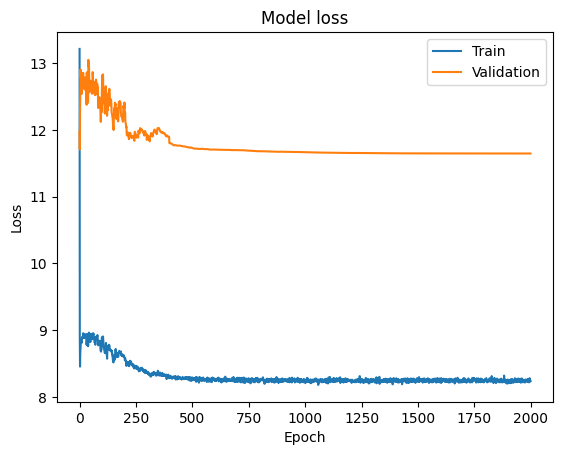

In [ ]:
import matplotlib.pyplot as plt

plt.plot(transformer.history.history['loss'])
plt.plot(transformer.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Inference

The `predict_text` function generates a text prediction using a trained Transformer model. It takes an input string, tokenizes it, and pads the sequence to a specified maximum length to match the model's input size. The function then uses the Transformer model to predict the output based on the padded sequence. The predicted output is converted back to text by identifying the highest probability token indices and mapping them back to words using the tokenizer. Finally, the function returns the predicted text as a string. This process allows the Transformer model to generate a response based on the input text.

In [ ]:
def predict_text(input_text, transformer, tokenizer, max_length=10):
    """
    Function to predict the response from the Transformer model for a given input text.

    Parameters:
    input_text (str): The input string to predict.
    transformer (tf.keras.Model): The trained Transformer model.
    tokenizer (Tokenizer): The tokenizer used for training.
    max_length (int): The maximum length for padding sequences.

    Returns:
    str: The predicted text output.
    """
    # Step 1: Tokenize the input text
    input_sequence = tokenizer.texts_to_sequences([input_text])

    # Step 2: Pad the sequence to match the model's input size
    input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post')

    # Step 3: Make prediction using the Transformer model
    predicted_output = transformer.predict(input_padded)

    # Step 4: Convert predicted output back to text
    predicted_sequence = np.argmax(predicted_output, axis=-1)  # Get the index of the highest probability for each token
    predicted_text = sequences_to_text(predicted_sequence, tokenizer)

    return predicted_text[0]  # Return the first element as a single string

In [ ]:
# Test the function with the example input
input_text = "What is the capital of France?"
predicted_response = predict_text(input_text, transformer, tokenizer)
print("Predicted Response:", predicted_response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Predicted Response: what is ? capital france france


The provided code defines a function, `push_model_to_huggingface`, to upload a TensorFlow Transformer model to the Hugging Face Hub. It authenticates using a token, creates a repository, and uploads the model, configuration file, and optionally, a tokenizer. The function also generates and uploads a README file containing a model card with YAML metadata, describing the model’s details, usage, and limitations. It handles potential exceptions and returns success or error messages accordingly. After uploading, it cleans up temporary files created during the process.

## Save to HuggingFace cloud

In [ ]:
from huggingface_hub import HfFolder, create_repo, upload_file
from transformers import AutoConfig
import os
import json
import pickle

In [ ]:
def push_model_to_huggingface(token, account_name, transformer_model, model_name, tokenizer=None):
    """
    Push a TensorFlow Transformer model to Hugging Face Hub, including config.json and tokenizer (if available),
    and add a model card with YAML metadata.

    Parameters:
    token (str): Hugging Face token for authentication.
    account_name (str): Hugging Face account username.
    transformer_model (tf.keras.Model): Trained Transformer model to upload.
    model_name (str): Desired model name on Hugging Face Hub.
    tokenizer (Tokenizer, optional): The tokenizer used for training the model.

    Returns:
    str: Success or error statement based on the result of the upload.
    """
    # Authenticate with Hugging Face Hub
    HfFolder.save_token(token)

    # Create repository name in "account_name/model_name" format
    repo_id = f"{account_name}/{model_name}"

    try:
        # Create the repository on Hugging Face Hub
        create_repo(repo_id, exist_ok=True)

        # Save the model locally with a .keras extension
        model_save_path = "./tmp_model.keras"
        transformer_model.save(model_save_path)

        # Extract model configuration and save to config.json
        config = transformer_model.get_config()  # Get the model configuration as a dictionary
        config_save_path = "./config.json"
        with open(config_save_path, "w") as config_file:
            json.dump(config, config_file)

        # Upload the saved model file to Hugging Face Hub
        upload_file(
            path_or_fileobj=model_save_path,
            path_in_repo=model_name + ".keras",
            repo_id=repo_id,
            repo_type="model"
        )

        # Upload the config.json to Hugging Face Hub
        upload_file(
            path_or_fileobj=config_save_path,
            path_in_repo="config.json",
            repo_id=repo_id,
            repo_type="model"
        )

        # Optionally, upload the tokenizer if provided
        if tokenizer:
            # Save tokenizer configuration and vocabulary manually
            tokenizer_config_path = "./tokenizer_config.json"
            vocab_path = "./vocab.pkl"

            # Save tokenizer configuration to JSON
            tokenizer_config = {
                "word_index": tokenizer.word_index,
                "index_word": tokenizer.index_word,
                "num_words": tokenizer.num_words,
                "filters": tokenizer.filters,
                "lower": tokenizer.lower,
                "split": tokenizer.split,
                "char_level": tokenizer.char_level
            }
            with open(tokenizer_config_path, "w") as f:
                json.dump(tokenizer_config, f)

            # Save tokenizer word index to a pickle file
            with open(vocab_path, "wb") as f:
                pickle.dump(tokenizer.word_index, f)

            # Upload tokenizer files to Hugging Face Hub
            upload_file(
                path_or_fileobj=tokenizer_config_path,
                path_in_repo="tokenizer_config.json",
                repo_id=repo_id,
                repo_type="model"
            )
            upload_file(
                path_or_fileobj=vocab_path,
                path_in_repo="vocab.pkl",
                repo_id=repo_id,
                repo_type="model"
            )

        # Define YAML metadata for the model card
        yaml_metadata = """
        ---
        language: en
        license: apache-2.0
        tags:
          - question-answering
          - transformer
          - educational
        datasets:
          - custom
        metrics:
          - accuracy
        ---

        """

        # Define a template for the model card with YAML metadata
        model_card_content = """
        # Model Card for {model_name}

        ## Model Details
        This is a Transformer model trained for demonstration purposes. The model was trained using a dataset of question-answer pairs and is designed to understand simple natural language questions.

        ## Intended Use
        This model is intended for educational purposes and demonstrations. It is not suitable for production use or handling sensitive data.

        ## Limitations
        The model may not perform well on out-of-domain questions or complex natural language understanding tasks.

        ## Training Data
        The model was trained on a small dataset of questions and answers created for this demonstration.
        """.format(model_name=model_name)

        # Combine YAML metadata and model card content
        full_model_card_content = yaml_metadata + model_card_content

        # Save the model card content to a local README.md file
        readme_path = "./README.md"
        with open(readme_path, "w") as f:
            f.write(full_model_card_content)

        # Upload the README.md (model card) to Hugging Face Hub
        upload_file(
            path_or_fileobj=readme_path,
            path_in_repo="README.md",
            repo_id=repo_id,
            repo_type="model"
        )

        # Clean up local saved files after uploading
        os.remove(model_save_path)
        os.remove(config_save_path)
        os.remove(readme_path)
        if tokenizer:
            os.remove(tokenizer_config_path)
            os.remove(vocab_path)

        return "Model, config, tokenizer, and model card pushed successfully to Hugging Face Hub with YAML metadata."

    except Exception as e:
        return f"Error occurred while pushing the model: {str(e)}"


In [ ]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [ ]:
# Example usage:
huggingface_token = HF_TOKEN
account_name = "eagle0504"
model_name = "pretrained_transformer_model_v5"

# Call the function to push the model
# result = push_model_to_huggingface(huggingface_token, account_name, transformer, model_name)
result = push_model_to_huggingface(huggingface_token, account_name, transformer, model_name, tokenizer)
print(result)

tmp_model.keras:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

vocab.pkl:   0%|          | 0.00/258 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:3664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


Model, config, tokenizer, and model card pushed successfully to Hugging Face Hub with YAML metadata.


The code downloads a pre-trained Transformer model and its tokenizer from the Hugging Face Hub using specified repository and model names. It loads the model into TensorFlow, compiles it for further training, and retrieves tokenizer configuration and vocabulary files. The tokenizer is recreated using TensorFlow's `Tokenizer` class, configured with the loaded settings and vocabulary. After setting up the model and tokenizer, it cleans up by removing the downloaded configuration and vocabulary files. The model is then ready for further training or inference tasks.

## Load model from cloud

In [ ]:
from huggingface_hub import hf_hub_download
import tensorflow as tf
import os
import json
import pickle

# Define the Hugging Face model repository path
model_repo_url = f"{account_name}/{model_name}"

# Step 1: Download the model file from Hugging Face
model_filename = f"{model_name}.keras"
model_file_path = hf_hub_download(repo_id=model_repo_url, filename=model_filename, use_auth_token=huggingface_token)

# Step 2: Load the pre-trained model from the downloaded file
pre_trained_transformer = tf.keras.models.load_model(model_file_path, custom_objects={"TransformerModel": TransformerModel})

# Step 3: Compile the model to prepare for further training
pre_trained_transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 4: Reload the tokenizer (if used) by downloading tokenizer files from Hugging Face
tokenizer_config_path = hf_hub_download(repo_id=model_repo_url, filename="tokenizer_config.json", use_auth_token=huggingface_token)
vocab_path = hf_hub_download(repo_id=model_repo_url, filename="vocab.pkl", use_auth_token=huggingface_token)

# Load the tokenizer configuration from the downloaded file
with open(tokenizer_config_path, "r") as f:
    tokenizer_config = json.load(f)

# Recreate the tokenizer using TensorFlow's Tokenizer class
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(
    num_words=tokenizer_config.get("num_words"),
    filters=tokenizer_config.get("filters"),
    lower=tokenizer_config.get("lower"),
    split=tokenizer_config.get("split"),
    char_level=tokenizer_config.get("char_level")
)
tokenizer.word_index = tokenizer_config.get("word_index")
tokenizer.index_word = tokenizer_config.get("index_word")

# Load the vocabulary from the pickle file
with open(vocab_path, "rb") as f:
    tokenizer.word_index = pickle.load(f)

# Clean up downloaded files
os.remove(tokenizer_config_path)
os.remove(vocab_path)

pretrained_transformer_model_v5.keras:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/812 [00:00<?, ?B/s]

vocab.pkl:   0%|          | 0.00/258 [00:00<?, ?B/s]

### Training again

In [ ]:
# Step 5: Now you can continue training your pre-trained model
# Prepare your sample_data and call fit again
pre_trained_transformer.fit(sample_data, sample_data, epochs=1000)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7375 - loss: 2.4196
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7375 - loss: 2.4205
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7375 - loss: 2.4194
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7375 - loss: 2.4196
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7375 - loss: 2.4195
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7375 - loss: 2.4253
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7375 - loss: 2.5372
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7375 - loss: 2.4195
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7375 - loss: 2.4194
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7375 - loss: 2.4219
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7375 - loss: 2.4194
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - a

In [ ]:
# Test the function with the example input
input_text = "What is the capital of France?"
predicted_response = predict_text(input_text, pre_trained_transformer, tokenizer)
print("Predicted Response:", predicted_response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Response: what is ? capital ? france
